In [1]:
# Check if TF is using gpu
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 973672732416606803
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6727654441
locality {
  bus_id: 1
}
incarnation: 6047036463151217013
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [2]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [3]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

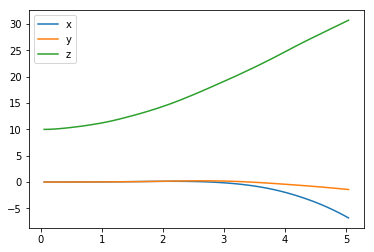

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

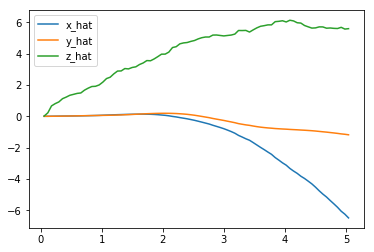

In [5]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Next, you can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

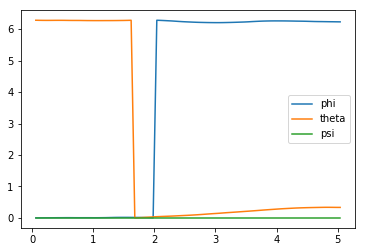

In [6]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

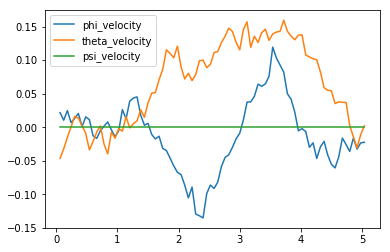

In [7]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, you can use the code cell below to print the agent's choice of actions.  

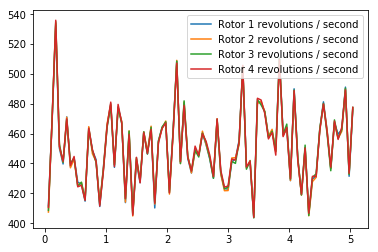

In [8]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [9]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[ -6.81760691  -1.42719694  30.73670815   6.23133878   0.33410162   0.        ]
[-6.4914886  -1.18061814  5.59938854]
[-0.0224457   0.00211938  0.        ]


In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

In [10]:
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 1

target_pos = np.array([50., 50., 50.])
init_pos = np.array([0., 0., 0., 0., 0., 0.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode =    1, score =  -2.985 (best =  -2.985), noise_scale = 0.05

This agent should perform very poorly on this task.  And that's where you come in!

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [11]:
## TODO: Train your agent here.
from agents.DDPG import DDPG
import numpy as np
import sys
import pandas as pd

num_episodes = 1500
initial_pos = np.array([0., 0., 20., 0., 0., 0.])
initial_velocity = (0., 0., 20.)

run_time= 5.0
target_pos = np.array([0., 0., 30.])
task = Task(target_pos=target_pos)
agent = DDPG(task) 


# Results log
results = {x : [] for x in labels}
# Best reward initialized is negative infinity
highest_score = -np.Inf
# Total rewards list
totalRewards = []
counter = []

file_output = 'results-ddpg.txt'
# Setting up the writer
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    
    for i_episode in range(1, num_episodes+1):
        state = agent.reset_episode() # start a new episode

        total_reward = 0
        while True:
            action = agent.act(state) 
            next_state, reward, done = task.step(action)
            
            # Calculating the total reward
            total_reward += reward
            to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
            
            agent.step(action, reward, next_state, done)
            state = next_state
            
            for ii in range(len(labels)):
                results[labels[ii]].append(to_write[ii])
                writer.writerow(to_write)
            
            if done:
                if (total_reward > highest_score):
                    highest_score = total_reward
                
                counter.append(i_episode)
                totalRewards.append(total_reward)
                
                print("\nEpisode: {}  Reward: {} highScore: {}".format(i_episode, total_reward, highest_score))
                print(to_write)
                break
        sys.stdout.flush()

Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead

Episode: 1  Reward: -78.98212568820657 highScore: -78.98212568820657
[1.9200000000000013, 3.4881022194272102, 3.6641148145744338, 0.0, 4.9455336055465295, 4.5693001675197102, 0.0, 2.989528977036469, 1.1985960999673571, -14.039356463476013, -9.1545603240756055, -3.602427468196626, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 2  Reward: -79.66769136715205 highScore: -78.98212568820657
[1.9200000000000013, 3.6226282558007767, 3.9409806223638015, 0.0, 4.9859795826076052, 4.2546820589927705, 0.0, 3.2227102302102741, 1.5599806945563413, -14.395642357443824, -8.9633689913144448, -4.0227871711464038, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 3  Reward: -80.10891801319735 highScore: -78.98212568820657
[1.9200000000000013, 5.3759157060038385, 3.1421096745480641, 0.0, 2.4629189993393084, 6.1866601550429809, 0.0, 3.261600686649


Episode: 23  Reward: -57.92189473575457 highScore: -12.954105213688855
[1.2000000000000006, 0.26644255213578699, -2.9758705510800998, 0.0, 3.9437668343196908, 2.0186380153930745, 0.0, -0.4858764790508362, -3.8985460786977169, -17.019391891353198, 5.2288235107304084, 11.029918893020586, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 24  Reward: -58.00981955165457 highScore: -12.954105213688855
[1.2000000000000006, -0.45492904667234624, 2.57905315681489, 0.0, 2.6118474525740609, 4.2627421591346693, 0.0, -1.7362001641054128, 4.1382034702504198, -15.401907735719872, -2.8718550408199977, 2.6561481902876087, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 25  Reward: -188.3739810773014 highScore: -12.954105213688855
[3.900000000000003, 3.2583980823707881, 5.1703117629159223, 0.0, 5.5166215195245698, 6.2498058632002333, 0.0, 1.27403053111966, 5.8112461974767697, -13.295294838498572, -26.038803047967772


Episode: 46  Reward: -70.25235505391208 highScore: -12.954105213688855
[1.560000000000001, -0.57659746953431668, 0.072020283883428501, 0.0, 6.1367508672122533, 5.0440225329347186, 0.0, -1.3125860457859277, -0.093884218423745641, -14.887223840501106, 14.185187362240855, -14.025345654418835, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 47  Reward: -70.25073874376375 highScore: -12.954105213688855
[1.560000000000001, -0.3618069521459944, 0.011747043482672151, 0.0, 5.5411524297081947, 4.6137123656482188, 0.0, -1.1076689591910887, -0.4210993548423938, -14.741605900582982, 14.530756114648854, -13.803094896970245, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 48  Reward: -70.51696297496292 highScore: -12.954105213688855
[1.560000000000001, -0.48511018670163525, -0.024193691882856767, 0.0, 4.8763152083978767, 3.8349621363644744, 0.0, -1.2796692756119843, -0.35467739678778265, -14.7740732133134, 14.4


Episode: 69  Reward: -66.943855052912 highScore: -12.954105213688855
[1.3800000000000008, -1.3640835442906416, 3.7433869036046445, 0.0, 6.2807397243067431, 1.9937940041789766, 0.0, -0.66012415609252495, 3.7734223313623874, -13.168031054596398, 6.4466951627949918, -28.70280220431146, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 70  Reward: -76.02636218461451 highScore: -12.954105213688855
[1.560000000000001, -2.0401306501821943, -3.9224432610862752, 0.0, 6.1301765001161517, 0.94617866584249022, 0.0, -2.46573896317047, -2.8539729003157692, -16.744784963023729, 13.59285656025234, -25.110425918439354, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 71  Reward: -78.82427518742756 highScore: -12.954105213688855
[1.620000000000001, -2.8030804578078907, -2.9710372847868878, 0.0, 1.4919945784834763, 5.658819969116502, 0.0, -3.6259676690089422, -3.7918791459794332, -16.5402834722608, 16.31437032737313, 


Episode: 92  Reward: -64.9045653944226 highScore: -12.954105213688855
[1.3800000000000008, 2.2399239144153462, 2.7322986300853689, 0.0, 4.6595637678901021, 5.337772447117235, 0.0, 0.82286204025581111, 2.4038206076791142, -15.910487660967183, 5.1468578738308794, -25.847791767374606, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 93  Reward: -71.48790819956349 highScore: -12.954105213688855
[1.5000000000000009, -1.0795685962549306, -1.0527178477364583, 0.0, 4.2076383281305834, 2.11339287876471, 0.0, 0.37870716735208465, -0.86782441739144622, -11.101067512828982, 9.0133909981698217, -24.1498595577517, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 94  Reward: -78.31269942892833 highScore: -12.954105213688855
[1.620000000000001, -7.1845118750958719, -2.4135298224848829, 0.0, 3.4590491963410059, 5.3988893650888699, 0.0, -6.1321816299523668, -1.9591921635607137, -14.419376472833537, 13.67276978450850


Episode: 115  Reward: -68.71498890943069 highScore: -12.954105213688855
[1.560000000000001, -5.3966984363065746, -0.58241171689851623, 0.0, 1.4438830244097094, 3.9668767143403088, 0.0, -4.171820316398553, -0.45387453701778202, -15.10196589288654, 11.078277841559455, -10.328628419921383, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 116  Reward: -68.09142472825778 highScore: -12.954105213688855
[1.560000000000001, -5.5756657515475165, -0.58667098119839656, 0.0, 1.5724787637707482, 5.1229657161996371, 0.0, -3.9155022361383494, -0.18733372135476717, -14.280323703031021, 15.500147573508375, -10.021805522884463, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 117  Reward: -71.29782718341582 highScore: -12.954105213688855
[1.560000000000001, -2.3099317564390418, -0.58206083107606499, 0.0, 4.5656731929763339, 1.3477195408229266, 0.0, -5.4745103682777652, -1.1353636077297682, -14.056972337721337, 12.33


Episode: 137  Reward: -71.2895478280683 highScore: -12.954105213688855
[1.560000000000001, -0.61147363437060798, 0.44003921268744756, 0.0, 3.1206406305443544, 5.2048928103012226, 0.0, -2.1688438088388029, 0.54813310606311794, -14.511724600297326, 12.580888306337762, -10.580550994823939, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 138  Reward: -71.28536105361121 highScore: -12.954105213688855
[1.560000000000001, -0.54777543236955173, 0.44143038936481221, 0.0, 3.3497559977019655, 0.17011282694841157, 0.0, -1.6583488537227669, 0.47697777121495938, -14.50871885537277, 12.427617833738996, -12.268306205793053, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 139  Reward: -70.76343284096367 highScore: -12.954105213688855
[1.560000000000001, -0.7382585376489369, 0.3703809313621112, 0.0, 0.93499920411081661, 6.1592778249639935, 0.0, -2.0688957540913933, 0.86198949186146234, -14.411869085384584, 15.2157


Episode: 159  Reward: -68.23849645725664 highScore: -12.954105213688855
[1.5000000000000009, -0.60536957353687981, 0.30041884823728199, 0.0, 3.2266544876118939, 0.22229345667131817, 0.0, -1.8326250978879524, -0.086359574062232866, -14.273180364164824, 12.1685688177917, -19.450619374180786, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 160  Reward: -70.82638142686173 highScore: -12.954105213688855
[1.560000000000001, -0.047413406501522447, 0.20150763719721301, 0.0, 1.9086091819384983, 1.2078394246246855, 0.0, -0.77358174360899157, -0.010400375273904252, -14.415169225877145, 10.321619921221675, -23.860007270022994, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 161  Reward: -68.66130698426699 highScore: -12.954105213688855
[1.5000000000000009, 0.37429361909804953, 0.2426211168106453, 0.0, 1.5213437000304184, 1.2325037973564168, 0.0, -0.40584187020730245, 0.44726042975956687, -14.826923854949506,


Episode: 181  Reward: -70.73044425106207 highScore: -12.954105213688855
[1.5000000000000009, -0.13782661278469663, -0.57726285894404505, 0.0, 4.6515030202939904, 2.9359682380963221, 0.0, -0.88443482897816716, -0.058279586387324167, -14.484991905517443, 10.328843069623398, -25.776409813744117, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 182  Reward: -72.93928628467515 highScore: -12.954105213688855
[1.5000000000000009, -0.4134455878325779, -0.57540494446427748, 0.0, 5.0519905671173131, 0.081853417999275813, 0.0, -0.10726208285528664, -0.82751474690689586, -15.140415512143539, 8.7074652727219526, -25.553611639927766, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 183  Reward: -70.13410448917577 highScore: -12.954105213688855
[1.4400000000000008, -2.0357530923098843, -0.58575141236638151, 0.0, 4.0567091585738773, 2.8033951409510429, 0.0, -3.2578225546995041, 0.011222361927174032, -14.3735223063


Episode: 203  Reward: -75.1063312540534 highScore: -12.954105213688855
[1.620000000000001, 1.5560420067539187, 1.0022613364298323, 0.0, 0.37597628406118044, 5.9056261265356227, 0.0, -0.01533691172095559, 0.32738120705749857, -14.535460715746851, 6.7293200460576097, -25.460358981797551, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 204  Reward: -70.86077392270656 highScore: -12.954105213688855
[1.5000000000000009, 1.6965485258547142, 0.49760618297250875, 0.0, 0.34484078866781687, 0.55445223486579032, 0.0, 2.3569227086007638, 0.30182340550421588, -14.84740640896579, 9.6344620424405907, -23.784401895961448, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 205  Reward: -72.72599478884092 highScore: -12.954105213688855
[1.560000000000001, 0.74660535073368961, 0.8500088773359552, 0.0, 5.7862548130712135, 1.7662118798962485, 0.0, 1.362517786583485, 0.82880825944704328, -14.704404317930678, 9.5542462669


Episode: 225  Reward: -73.9223871614357 highScore: -12.954105213688855
[1.5000000000000009, -0.061299779578331881, 0.91544242370159956, 0.0, 6.0985458583222751, 3.5196708206642473, 0.0, 0.14923836367079657, 0.52629073084581357, -14.360212242554608, 2.6661404755786817, -18.826791132148504, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 226  Reward: -73.99933042060641 highScore: -12.954105213688855
[1.5000000000000009, -0.20514096772478513, 0.42520100951190576, 0.0, 5.7830918135418496, 3.7362999206980394, 0.0, -0.35986974001226063, -0.31828154488855087, -15.236780192023154, 2.0263606380719095, -18.355227774184609, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 227  Reward: -79.89038386999763 highScore: -12.954105213688855
[1.620000000000001, 0.0063576321674127505, -1.3647456380828906, 0.0, 4.2775962658997173, 4.1064952713825722, 0.0, -0.38340624409392021, -0.46191847626757787, -12.625304944628999


Episode: 247  Reward: -63.917524504372025 highScore: -12.954105213688855
[1.3200000000000007, -0.846494688500388, 2.3178727778545856, 0.0, 3.1415707808779807, 1.6381552573182194, 0.0, -1.8350129841455645, 3.5880725084975054, -11.196222388339029, -14.569321996395997, -27.872747519340201, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 248  Reward: -72.16361579955922 highScore: -12.954105213688855
[1.560000000000001, -0.45026088996398761, 4.9764767979602791, 0.0, 3.8220176724836445, 0.62567617577917822, 0.0, -0.97278407096823283, 5.7475887208735852, -14.404367544951279, -18.301296560996295, -28.556287120924949, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 249  Reward: -49.00370505902074 highScore: -12.954105213688855
[1.740000000000001, -1.262544452997628, -4.6483068669738268, 0.0, 5.32917659515347, 0.30573574818947868, 0.0, -4.0002889506054853, -2.0198179667086977, -13.605655124689955, -25.1647


Episode: 269  Reward: -77.5500520098978 highScore: -12.954105213688855
[2.1600000000000015, -0.79656693224537078, 6.7842701105283139, 0.0, 1.1339143292166352, 3.0238718914094456, 0.0, -3.6784996133687105, 4.1175230782375776, -13.45322277217516, -19.214159540814371, -13.618104242858838, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 270  Reward: -26.737009887393505 highScore: -12.954105213688855
[1.620000000000001, -0.51430586141890322, 11.42256213432384, 0.0, 1.2874699532245248, 1.1877336835495385, 0.0, -4.1829454300842812, 9.1653450054430721, -16.583663162428589, -21.513776800074535, -9.5340393583060639, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 271  Reward: -46.05333158220829 highScore: -12.954105213688855
[1.3200000000000007, -0.084204384658349021, 9.4865050707430569, 0.0, 0.4885998116489576, 0.14944243761899045, 0.0, -0.86050564517843342, 11.169000821149687, -15.694238396233965, -28.20


Episode: 292  Reward: -62.83330502473756 highScore: 11.910467400561586
[1.740000000000001, -2.3369894954375128, 6.2946721411900777, 0.0, 1.4307569408734189, 4.4483526538594163, 0.0, -2.7020477210680807, 2.5596713797195001, -13.442666506554522, -13.051596482876493, -9.6177055960108291, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 293  Reward: -64.11911654198789 highScore: 11.910467400561586
[1.740000000000001, 1.1269481378435653, 6.9809678057424138, 0.0, 3.9121941035310961, 4.1117696196999489, 0.0, 0.97755019878929927, 4.5167500759063186, -14.576842930729068, -14.954835178706496, -24.460603029831507, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 294  Reward: -63.183206152354316 highScore: 11.910467400561586
[1.740000000000001, 0.27379351003715702, 6.7392443960074164, 0.0, 5.219460623001785, 5.1021405969443698, 0.0, 2.3709927304005505, 3.5375833100855929, -14.534250250218793, -16.1367537667284


Episode: 314  Reward: -7.772334073861856 highScore: 11.910467400561586
[2.0400000000000014, 11.925002884595985, -0.00032662921682035778, 0.0, 0.00013526204959646293, 0.46784359669629261, 0.0, 6.8682388591539087, -0.0003955101477986911, -18.566884918501003, 0.00010045122627391552, -28.822205631366362, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 315  Reward: 67.92621167067657 highScore: 67.92621167067657
[5.0399999999999805, 64.452203474911016, 0.0021129945191900672, 18.398500872990873, 0.00021879285472969912, 4.2760800810383088, 0.0, 18.017846255988157, 0.00057707291937986519, -18.097595573558728, 5.0302309689227008e-05, -28.840276100534744, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 316  Reward: -67.13804721700062 highScore: 67.92621167067657
[1.4400000000000008, 1.5823385800216878, -1.2048407078976051e-06, 0.0, 1.3836336566264151e-05, 2.5512750022500512, 0.0, 1.4922652742318752, 5.35756


Episode: 336  Reward: -62.78102522016991 highScore: 67.92621167067657
[1.740000000000001, -1.6013071630242242, 1.9031692566244345, 0.0, 5.8262407804968213, 1.9038152580932106, 0.0, -5.4732311713950326, 0.19083244391299348, -15.04920509015996, 23.142593447474137, -2.8853407620251765, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 337  Reward: -60.009942482672884 highScore: 67.92621167067657
[1.680000000000001, 1.2716867159937666, 1.8991230661334664, 0.0, 4.3340322470636856, 6.033308045401462, 0.0, 3.4756819162720078, 0.71520197276916198, -15.217464349814678, 11.544308857509508, -0.18022437912896783, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 338  Reward: -62.85156111602555 highScore: 67.92621167067657
[1.740000000000001, -2.3850335840536401, 1.960241030550657, 0.0, 2.1741936002952063, 1.0876870562125625, 0.0, -7.6118181011646344, 0.31458274556172838, -14.221338070695147, 22.586792312116543, 


Episode: 359  Reward: -59.85510627171696 highScore: 67.92621167067657
[1.680000000000001, -0.39732465896934538, 1.9790231631901649, 0.0, 0.95545945497234985, 0.15513951341308463, 0.0, -3.0925124982478831, 0.54427342842021897, -14.747149034156699, 28.831382186628822, -11.979533726304295, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 360  Reward: -62.8559061890914 highScore: 67.92621167067657
[1.740000000000001, 1.907218772549403, 1.8055661042046185, 0.0, 5.397270336454806, 6.0550860288107131, 0.0, 4.2878576598824782, -0.64678913739537713, -15.238474651325978, 9.3646606378768205, 0.077040934571010647, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 361  Reward: -62.67699563223752 highScore: 67.92621167067657
[1.740000000000001, 0.69520365538523188, 1.5613283722905564, 0.0, 5.0862694009081455, 3.760200967748677, 0.0, 3.4490361293441287, -0.16293704241645651, -13.852512806284912, 13.650802331957685


Episode: 382  Reward: -59.850842201964966 highScore: 67.92621167067657
[1.680000000000001, 1.6436417684122264, 1.7673564875425782, 0.0, 4.8103178921029226, 2.7095748330109721, 0.0, 2.0319823596584161, 0.2700167541964027, -15.168440049072007, 19.174626146323824, -16.777837913494402, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 383  Reward: -59.93325035260648 highScore: 67.92621167067657
[1.680000000000001, -1.2287597641504093, 2.0189841437178795, 0.0, 0.94664919464930186, 5.2674799035078372, 0.0, -2.2293728851797989, 0.2127432549790913, -15.682072755200332, 28.570188205371824, -6.7979358723988224, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 384  Reward: -62.737736796739924 highScore: 67.92621167067657
[1.740000000000001, -3.2397647466226909, 1.9048886116991526, 0.0, 5.1472608097177641, 0.54337770033384025, 0.0, -7.8639044674013689, 0.29340369686586698, -13.951527242493151, 15.81734670187706


Episode: 405  Reward: -62.76981186374019 highScore: 67.92621167067657
[1.740000000000001, -0.93932281898701542, 1.899207461083291, 0.0, 3.172045496998388, 3.577343935557078, 0.0, -0.79706613978356522, -0.31484172696220442, -15.297032360289181, 20.088881064601139, -9.2323591763533379, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 406  Reward: -62.86431358178445 highScore: 67.92621167067657
[1.740000000000001, -3.6640466975638719, 2.0029687968749252, 0.0, 3.0888223137617352, 3.7969690060125032, 0.0, -7.9531588852477384, 0.33234118311700866, -14.192443282797038, 20.110857792425939, -6.9254402804477913, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 407  Reward: -62.84332077241121 highScore: 67.92621167067657
[1.740000000000001, 0.91131694510429329, 1.8596816090937867, 0.0, 4.585964017814522, 6.2450296350910932, 0.0, 1.4850971872764094, 0.48110445506156907, -15.497465722214779, 9.3271295463321806,


Episode: 428  Reward: -62.832209809250145 highScore: 67.92621167067657
[1.740000000000001, 1.574214147225319, 1.8664981957776348, 0.0, 4.4598928755526686, 3.0209360326194243, 0.0, 3.8468238955353051, 1.1766863124910025, -14.659339451164103, 9.3216670442669418, -13.084075966554355, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 429  Reward: -63.008539949249126 highScore: 67.92621167067657
[1.740000000000001, -1.3057526833990447, 2.1405004479746328, 0.0, 6.1094127655300312, 0.26056522560975992, 0.0, -3.2123418969578297, 1.5075952644762454, -13.995865055223179, 15.531693658440089, -14.935083956098509, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 430  Reward: -62.76260036573629 highScore: 67.92621167067657
[1.740000000000001, 4.3061546327677096, 1.8370127137030241, 0.0, 3.3313736595929839, 3.0393632546560081, 0.0, 7.7030006495597041, 0.61738962333362435, -13.519318203674597, 10.575985053696602, -


Episode: 451  Reward: -59.90239732185814 highScore: 67.92621167067657
[1.680000000000001, 0.70207871804837751, 0.69332807956742304, 0.0, 4.8156669041736642, 0.58663473724757864, 0.0, 4.1376606130249254, -2.9843222431456007, -13.841256630079464, 24.027693541587166, -26.529250762916885, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 452  Reward: -59.77469551232673 highScore: 67.92621167067657
[1.680000000000001, -0.97518815391834035, 0.99317221596963579, 0.0, 5.5087761397650148, 0.19111243752078089, 0.0, -3.1756776055910874, -3.7278346564820906, -14.373176058832259, 19.513223901929027, -12.525010321615101, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 453  Reward: -62.76001350627426 highScore: 67.92621167067657
[1.740000000000001, -1.4119859301851356, 1.7874811088275029, 0.0, 5.886061940999106, 4.1237402687892057, 0.0, -1.3674575484898326, 1.0458407991769509, -13.976695504921851, 18.812289245313


Episode: 474  Reward: -71.89737705157229 highScore: 67.92621167067657
[1.9200000000000013, 5.4902930597899999, 2.3692459186954715, 0.0, 1.5934655532629307, 4.7620129693733109, 0.0, 3.4563333216353644, 1.6659127912856802, -8.5954250523753526, 28.848762117443503, -28.859152031922868, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 475  Reward: -62.79959600461386 highScore: 67.92621167067657
[1.740000000000001, -0.54198659887887679, 1.6766827494664156, 0.0, 2.7375598190530113, 5.5489141827208144, 0.0, -3.9008002026976647, 1.9387555459705403, -13.29378173405688, 28.834452200334493, -28.085632998680762, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 476  Reward: -62.92622206525931 highScore: 67.92621167067657
[1.740000000000001, -2.0662945627354681, 2.1843379327437771, 0.0, 2.7207985871072289, 5.2408435897046903, 0.0, -6.7991192217966692, 3.2766257003956047, -12.824828419759941, 28.83750246379752, -2


Episode: 497  Reward: -62.8719611337951 highScore: 67.92621167067657
[1.740000000000001, 2.6876027976649506, 2.0466099416965426, 0.0, 2.706961227220976, 5.9902538855887926, 0.0, 5.5191129351250527, 2.0627037492301712, -13.999442195872309, 28.849546292981653, -0.35368708545860233, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 498  Reward: -63.050720583851685 highScore: 67.92621167067657
[1.740000000000001, -1.0771299201620699, 2.1099134404341817, 0.0, 2.7122482761855835, 4.4411286685657583, 0.0, 2.7374291745907504, 0.68560951015820404, -13.400287871780272, 28.834694374683536, -8.1960309186792415, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 499  Reward: -62.853651519418406 highScore: 67.92621167067657
[1.740000000000001, 1.0740012633444334, 2.0580158274148284, 0.0, 2.7603882244406908, 6.1227617680699034, 0.0, 2.4107244926921463, 2.1518417430054231, -14.258690840918128, 28.849758990692983, -0.


Episode: 520  Reward: -62.734160080804386 highScore: 67.92621167067657
[1.740000000000001, 0.10239771633622535, 1.8936569625871651, 0.0, 2.6143246918147618, 6.2717478247365666, 0.0, 0.49946146044380568, 1.9225449318675614, -14.161682520853923, 28.773362273421132, 0.13680068582383847, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 521  Reward: -59.86589363839152 highScore: 67.92621167067657
[1.680000000000001, -0.37635501859687165, 1.9719376748040804, 0.0, 0.90012737515496877, 4.2047567744914289, 0.0, -2.1864676548028821, 0.52789422697846478, -15.750743079914329, 28.740529229396515, -8.1405604122559225, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 522  Reward: -62.752535768280794 highScore: 67.92621167067657
[1.740000000000001, 0.97754423918057942, 1.978462085789634, 0.0, 2.6829345853592734, 6.1287286311618026, 0.0, 2.3101328402328702, 2.0340344395036758, -14.189111370718029, 28.80645868361455


Episode: 543  Reward: -60.83765001286477 highScore: 67.92621167067657
[1.680000000000001, 7.3164232561255043, -0.29895827272125536, 0.0, 0.89671394995149889, 2.5695231507191334, 0.0, 8.5874238879042579, -2.2929125395258949, -14.265574367774944, 28.827754159749979, -19.73870328369383, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 544  Reward: -62.843548418385936 highScore: 67.92621167067657
[1.740000000000001, 6.5767522884098923, 1.9862374603598378, 0.0, 2.7334438016500577, 5.5120610814634841, 0.0, 13.542684239430161, 1.6718433195508557, -12.912216920879887, 28.829638343672588, -0.74743819129420053, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 545  Reward: -62.75142239580698 highScore: 67.92621167067657
[1.740000000000001, -2.5319855404081388, 2.0531173286552122, 0.0, 2.7224273087165454, 0.2059181059182702, 0.0, -5.7798216727302565, 1.3443679376265893, -14.383979260579366, 28.034794309595615,


Episode: 566  Reward: -51.31213594006594 highScore: 67.92621167067657
[1.8600000000000012, -0.49828892698831578, 1.6344091260675144, 0.0, 4.7559516186941178, 6.1623505420555045, 0.0, 0.25418290780178088, 0.59783654112590656, -18.4735937411306, 5.2699268682627718, -0.13995489930935257, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 567  Reward: -46.690433914033335 highScore: 67.92621167067657
[1.620000000000001, 1.2445204621878447, 2.0516282735411853, 0.0, 4.7289796227169028, 6.072532832809312, 0.0, 2.8627376290299402, -0.8071475972518859, -21.471509243548653, 3.0704093734845475, -0.16271782801740164, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 568  Reward: -62.790673180578814 highScore: 67.92621167067657
[1.740000000000001, -1.1423200422220174, 1.9106287650411902, 0.0, 3.760811451488232, 6.2138445375281588, 0.0, -1.7968447248140313, 1.2591092702668645, -14.501151661028242, 26.175601955778117


Episode: 588  Reward: -57.10474826084799 highScore: 172.72606306094846
[1.680000000000001, -12.739721820598975, 1.4803824763433859, 0.0, 5.007591607280931, 2.2141637597058601, 0.0, -7.7157458123676097, 2.7860656915662907, -14.61807619993896, -25.56398705615803, -3.6716490473251171, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 589  Reward: -61.08597398146153 highScore: 172.72606306094846
[1.8000000000000012, -7.3843876629747776, 0.54789867493284583, 0.0, 5.3014572449645492, 0.51097159148486426, 0.0, -5.2622984054410846, -0.031141852782255397, -14.19474615086764, -0.46503581602753741, -5.62970304048853, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 590  Reward: -105.10472716586045 highScore: 172.72606306094846
[2.4000000000000017, 6.1473981003575373, -8.3847385591896799, 0.0, 2.9044454515257652, 4.1233465073773061, 0.0, 6.3719150894279455, -7.9401867159338053, -12.444930650872708, 28.829822947


Episode: 611  Reward: -74.61667604729351 highScore: 172.72606306094846
[1.8000000000000012, -2.5514419090907143, 0.17213365066443345, 0.0, 4.5388779478813923, 4.0170674097800347, 0.0, -0.20758466498589279, -1.506340634487676, -15.409783085886879, 11.456902767795635, -10.71254752649388, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 612  Reward: -98.64928259358169 highScore: 172.72606306094846
[2.2800000000000016, 3.3697493650468728, -6.2213259487321055, 0.0, 5.1601768558643144, 2.074300367956285, 0.0, 8.5429450313249067, -4.6442431449715293, -14.612073552670394, 16.069762974400231, -3.2753551808885506, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 613  Reward: -108.44817722661028 highScore: 172.72606306094846
[2.4600000000000017, -6.3392445655413709, -7.9229738608660973, 0.0, 2.6605675976034782, 3.6682317071235353, 0.0, 5.3312062653572063, -6.3945722958556299, -12.810942507120847, 20.000338077


Episode: 633  Reward: -62.85877794286541 highScore: 172.72606306094846
[1.740000000000001, 1.7506296384482332, 1.7994803895958742, 0.0, 3.8818264402507605, 5.9804552944824678, 0.0, 4.9536549722482164, 1.3043835562728532, -15.126733507353537, 28.424686627164704, -0.21386551855863212, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 634  Reward: -62.778855548802156 highScore: 172.72606306094846
[1.740000000000001, -1.0995652294705995, 1.5646820775567025, 0.0, 4.7420364344115509, 6.0286589311977945, 0.0, -0.27686672838580284, 0.028815637913260805, -13.090192462456878, 21.262914168381254, -0.64502103977394776, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 635  Reward: -62.887667448863326 highScore: 172.72606306094846
[1.740000000000001, 0.43301565040976919, 1.7536566544938916, 0.0, 0.44896137712612116, 1.2774537464295932, 0.0, -2.3367989139075869, 0.13435194873850898, -15.582821574782987, 28.6291769


Episode: 655  Reward: -60.01567830103001 highScore: 172.72606306094846
[5.0399999999999805, -18.882877829892422, 0.00284551853504812, 80.408487792310851, 0.00034732246896407304, 0.27508972487906203, 0.0, -9.6576977542190043, 0.0036831553677997252, 15.475014313327959, 0.00015128269774725188, 0.038120600906563502, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 656  Reward: -60.015575323092264 highScore: 172.72606306094846
[5.0399999999999805, 34.741007710493712, -0.0016349391690503585, 71.452903393516863, 0.00011516030815528211, 5.1052265191338506, 0.0, 18.989689170852092, -0.00015808602186469491, 6.18012670437626, 5.0483787258478708e-05, -0.38736739178289281, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 657  Reward: -60.015679410435865 highScore: 172.72606306094846
[5.0399999999999805, -3.0856648821940222, -0.0067977291768755131, 82.728703575055192, 6.2830565525104305, 0.40987934008226201, 0.0


Episode: 676  Reward: -60.01568486982748 highScore: 172.72606306094846
[5.0399999999999805, 0.78093869463375576, 0.0020134553953270232, 82.922734050439985, 7.6141134234930519e-05, 5.9408230857984705, 0.0, 3.4845620124755019, 0.0014628897053549207, 17.089282887429224, 1.3973237826599561e-05, -0.090898798560057184, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 677  Reward: -60.01562205906366 highScore: 172.72606306094846
[5.0399999999999805, -4.5931946766690146, -0.011669068320200093, 82.670325923040494, 6.2827406471769756, 0.2538105439657059, 0.0, -2.9802132998861572, -0.008545337450636457, 17.033295988996567, -0.00012476573519551221, 0.22141583167839571, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 678  Reward: -60.01575720088226 highScore: 172.72606306094846
[5.0399999999999805, 12.280526315135399, 0.00058263377227337908, 82.558212166747779, 6.2831752143834212, 0.23308616882195299, 0.0, 1.0


Episode: 697  Reward: -60.01549976932468 highScore: 172.72606306094846
[5.0399999999999805, 2.5328304570312663, -0.00058462450358124903, 82.949664275812907, 6.2831255374989858, 0.34052177686960672, 0.0, -2.6136058298427618, -0.00061968110515567959, 17.264727489728969, -2.9256975373617694e-05, 0.11282630973698411, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 698  Reward: -32.178827619994536 highScore: 172.72606306094846
[5.0399999999999805, -47.583814621412628, 0.0027831521699373525, 59.299572157106525, 0.00016129646400564468, 1.6903357604028457, 0.0, -21.724223451459771, 0.0010648137184926054, -2.4508615749803822, 5.0361949856202903e-05, 0.3265725304052649, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 699  Reward: -58.01569872382393 highScore: 172.72606306094846
[5.0399999999999805, 38.02052491301005, 0.0062760378628064946, 70.51579043719299, 0.00028165820528247565, 5.5643634408371803, 0.0,


Episode: 718  Reward: -60.01575231945496 highScore: 172.72606306094846
[5.0399999999999805, -8.5928724209168266, 0.0032534319550933683, 82.320488565604762, 0.00022529044558883271, 0.1456521512239366, 0.0, -4.3995286419356399, 0.0033043114001980213, 16.857994223037394, 5.6893479131583786e-05, 0.069484413419301977, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 719  Reward: -60.01560866906985 highScore: 172.72606306094846
[5.0399999999999805, 9.1234839799836269, -0.019641263142225834, 82.642886131268583, 6.2826591424439115, 0.34721788189330649, 0.0, 1.8366465950992625, -0.012412834145588443, 17.730439296163574, -0.00011411420706023561, 0.42738042311543367, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 720  Reward: -60.01559414455485 highScore: 172.72606306094846
[5.0399999999999805, -20.349265096941934, 0.0014354362046218973, 79.018046783731435, 6.2831702382159769, 0.59316459920071551, 0.0, -12.


Episode: 739  Reward: -60.01556902415861 highScore: 172.72606306094846
[5.0399999999999805, -21.741677456115365, -0.0053047218906507997, 76.070761208514568, 6.2830596890172643, 1.5726235615750621, 0.0, -19.14921093143462, -0.0024090839860531313, 6.6053595925485062, 0.00017125365218241466, 0.45168012138635355, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 740  Reward: -60.01571118074699 highScore: 172.72606306094846
[5.0399999999999805, 8.5150235391976938, 0.0032537612548036612, 83.05173583954587, 0.00010826814028330745, 5.1963939097924197, 0.0, 11.26093207858009, 0.0020454668118962331, 15.753100255357152, 4.6260735365636379e-05, -0.41470876285955538, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 741  Reward: -60.015705894293305 highScore: 172.72606306094846
[5.0399999999999805, 33.638423566967916, 0.0073621317454234704, 72.056232559768219, 0.00027410559796603451, 4.6360737201398159, 0.0, 20.5


Episode: 760  Reward: -58.01557695865061 highScore: 172.72606306094846
[5.0399999999999805, 15.178342637193321, -0.0046460072983677712, 82.099695051194274, 6.2829791884805175, 0.14018918914147349, 0.0, 3.0750312008446836, -0.0035091413558803555, 17.517561107220974, -7.8926712154701227e-05, 0.12863493534337558, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 761  Reward: -60.015695973876944 highScore: 172.72606306094846
[5.0399999999999805, -18.560346520510524, 0.0019473625183710568, 80.752205189739286, 0.00016130711790296459, 0.054632171313046207, 0.0, -8.7018348936020864, 0.0021853591965471193, 16.154088181132426, 6.4549437202255662e-05, -0.42837157223498484, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 762  Reward: -60.01565892155752 highScore: 172.72606306094846
[5.0399999999999805, 16.533459404980526, -0.0027180012233506338, 81.155992713869182, 6.2830908243175045, 6.157287217775961, 0.0, 7


Episode: 781  Reward: -58.015662306121726 highScore: 172.72606306094846
[5.0399999999999805, 40.508734523136532, -0.0016584166037324508, 68.104133353318844, 6.2831404052240849, 5.0561543063415861, 0.0, 19.986344653495504, -0.00081344796038604437, 4.4757681735529822, 7.2262341553837128e-07, -0.33653594885550547, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 782  Reward: -60.0155876007621 highScore: 172.72606306094846
[5.0399999999999805, 34.526502699974642, -0.0032460757215693418, 71.130130112666762, 6.2827435101938995, 4.9592893200171773, 0.0, 19.979275412032717, -0.0023625627285382197, 4.504125661976774, -0.00014680707413958905, -0.1112874916140264, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 783  Reward: -60.01557337301318 highScore: 172.72606306094846
[5.0399999999999805, 13.605047413131675, 0.0021308895105345842, 81.040490865774387, 0.00010886524084519067, 5.2666125583787107, 0.0, 12.08


Episode: 802  Reward: -60.0155527087222 highScore: 172.72606306094846
[5.0399999999999805, -8.0193074377711735, -0.0097338593850252609, 82.406364222888854, 6.2829899120938606, 0.47618169007853517, 0.0, -5.3269598066559736, -0.0055736680327343174, 16.604556944087154, -1.4392890014018809e-05, 0.31583407716605794, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 803  Reward: -58.01566123795844 highScore: 172.72606306094846
[5.0399999999999805, -43.139611276215874, 0.00034036533800592541, 68.758693020599637, 9.4776312948852137e-05, 0.57597417868574485, 0.0, -22.450664845942612, 0.00068620836653202543, 7.0599942907531466, 3.3776193099593542e-05, 0.046168026832078345, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 804  Reward: -60.0156132483845 highScore: 172.72606306094846
[5.0399999999999805, 20.179532459449479, 0.0005408385511615568, 79.918325085977926, 3.3279851637146862e-05, 5.9616979150587142, 0.


Episode: 823  Reward: -60.01563032789066 highScore: 172.72606306094846
[5.0399999999999805, 23.204469978525328, -0.0021288044962297563, 78.021666884204777, 6.2831027659451557, 5.2014670170634432, 0.0, 17.091576550802717, -0.0009777732255244532, 9.5582771640687927, -3.6549548813991762e-05, -0.070911831483431984, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 824  Reward: -60.0156724894058 highScore: 172.72606306094846
[5.0399999999999805, 31.089954958700147, -0.020062048380165159, 73.336248399573364, 6.2823313782915911, 4.8268667830749123, 0.0, 19.157738151483567, -0.010521828508551708, 6.5378715378240768, -0.00021001834712760083, -0.33873949465806974, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 825  Reward: -60.01561163477314 highScore: 172.72606306094846
[5.0399999999999805, 29.39130382903604, -0.0050887485438501634, 74.683907793774992, 6.2829346901403902, 4.83909472576822, 0.0, 18.92359652


Episode: 844  Reward: -60.01560020328938 highScore: 172.72606306094846
[5.0399999999999805, -20.576773939511426, -0.00087531826604639947, 80.868551041569802, 1.536328783391383e-05, 6.2689326060531574, 0.0, -9.3407126357957537, -0.00011821178101698154, 17.002189696176455, 1.8632216708957495e-06, -0.061006536365045341, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 845  Reward: -60.01568852549693 highScore: 172.72606306094846
[5.0399999999999805, -6.3111436460599775, -0.00046894143774017728, 82.198220543786064, 0.00012335989980449824, 0.60169465527551669, 0.0, -8.011231681476195, 0.00045476765850900689, 15.767238058104162, 0.00010712822485729963, 0.33833994819444785, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 846  Reward: -60.015639223514015 highScore: 172.72606306094846
[5.0399999999999805, 11.521434282944792, -0.0061968362035001211, 82.002598808303219, 6.2829955982192818, 0.0494791582241731


Episode: 865  Reward: -60.015521838533246 highScore: 172.72606306094846
[5.0399999999999805, 9.6062358352547133, -0.011259160933237736, 82.46413101655078, 6.2827369894823981, 6.2719631429967571, 0.0, 3.2067160120858347, -0.0084115769428524442, 17.158272191174014, -0.00013923382788161978, 0.061527313579434369, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 866  Reward: -60.01568071471425 highScore: 172.72606306094846
[5.0399999999999805, 19.609560823666854, -0.014572240943968596, 79.308234616823071, 6.282845934684957, 5.625171553066485, 0.0, 12.27500618360739, -0.0076279386460275057, 13.48298832381232, -7.7643357882496629e-05, -0.26794256255326743, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 867  Reward: -60.015709908593294 highScore: 172.72606306094846
[5.0399999999999805, 12.295397444673828, -0.0035137299800555295, 81.478106358351468, 6.2830839982494879, 6.0416483635996592, 0.0, 7.894672243


Episode: 886  Reward: -60.01557787107575 highScore: 172.72606306094846
[5.0399999999999805, -15.555372415485252, -0.0013627419928340606, 81.477598527032228, 6.2831229727296147, 0.46606530082919573, 0.0, -7.7114837578655822, -0.0010144442173742915, 15.853619524315519, -1.8611954647234136e-05, 0.29860201550655358, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 887  Reward: -60.015587162568096 highScore: 172.72606306094846
[5.0399999999999805, 27.645579739098476, -0.00092771336981136647, 76.261929020576659, 6.2831822115387581, 5.5650803652467502, 0.0, 15.268337940284315, -0.00032897996622834898, 11.360804673192368, -1.2247111347222454e-05, -0.16559469430220114, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 888  Reward: -60.015594856180115 highScore: 172.72606306094846
[5.0399999999999805, -2.9862150906182729, 0.0042047582961191035, 82.712248592550267, 0.000148714595766819, 0.32633572490388651, 0.


Episode: 907  Reward: -60.015654867701514 highScore: 172.72606306094846
[5.0399999999999805, -32.110435343935762, 0.0029610874657963731, 71.157218751851502, 5.297493289457833e-05, 1.4351883235821328, 0.0, -19.843999225257569, 0.0011497598223502562, 4.4948775878961458, 1.435353204374823e-05, 0.50478050412972686, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 908  Reward: -60.01560917278047 highScore: 172.72606306094846
[5.0399999999999805, -34.698993651743031, 0.0036667810256596866, 69.442184308538273, 0.00029849015640781573, 1.5900158764850412, 0.0, -20.694518021391918, 0.0018651977644430879, 2.7098745296874918, 0.00010064386411588085, 0.35208289492433625, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 909  Reward: -60.01559898666568 highScore: 172.72606306094846
[5.0399999999999805, 28.746937441248011, 0.0044202127492001366, 74.659715187656261, 4.6115409486624515e-05, 5.2586151550100002, 0.0, 


Episode: 928  Reward: -60.015613680960655 highScore: 172.72606306094846
[5.0399999999999805, 23.038526746745621, 0.0010372243693075834, 77.548047856131021, 3.0428322458142532e-05, 5.2417032626691125, 0.0, 16.178440880076163, 0.00051604064837843281, 10.199914619397251, 8.3150742850031611e-06, -0.20916073511226738, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 929  Reward: -60.01567711958239 highScore: 172.72606306094846
[5.0399999999999805, 10.630753758406367, -0.0025577682844587337, 81.873543433521405, 6.2831384336776672, 6.136657217055431, 0.0, 6.3110587052738305, -0.0013218830225347369, 16.49438008714284, -9.2143505911861993e-06, 0.016993640529816178, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 930  Reward: -60.015593431707316 highScore: 172.72606306094846
[5.0399999999999805, -25.371665944407049, -0.0092044502846859895, 76.106841722767683, 6.2827759719796674, 1.1265954914622256, 0.0, -16


Episode: 949  Reward: -60.01569377384885 highScore: 172.72606306094846
[5.0399999999999805, -30.337838735967441, 0.0044175546457988933, 73.564795619014305, 0.00014237800919314481, 1.3798665671773307, 0.0, -18.614832369873618, 0.0021420597080574551, 6.818396495125695, 2.6796688666206833e-05, 0.5903399487036074, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 950  Reward: -60.015663877446 highScore: 172.72606306094846
[5.0399999999999805, -10.29794798848666, 0.00074288932380813248, 81.972241033444107, 0.00013236223001822367, 0.057158056149227754, 0.0, -6.2843905456830065, 0.001298033494679656, 16.762708870164108, 7.2096570622278184e-05, 0.037381507065758476, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 951  Reward: -60.01570414105039 highScore: 172.72606306094846
[5.0399999999999805, -6.5697346713482174, -0.0004552856710977261, 82.800616714377341, 6.2831577387883879, 0.18937516981235358, 0.0, -2


Episode: 970  Reward: -60.015676207160595 highScore: 172.72606306094846
[5.0399999999999805, 28.567671859204356, 0.0029752076407529413, 75.236434548865404, 0.00010360412579579759, 5.5434642573095516, 0.0, 16.589872197161469, 0.0018469037053048523, 10.090183095861603, 8.6493792128133987e-07, -0.016555396848013743, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 971  Reward: -59.059143178789554 highScore: 172.72606306094846
[5.0399999999999805, -37.470266721143794, -0.0013311550764193046, 66.700188805775014, 6.283106257256053, 1.836849395023048, 0.0, -21.711488635051747, -0.00050241854748549219, 0.0026735012226581367, -2.7001504702382546e-05, 0.4000875760418367, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 972  Reward: -60.015555571361745 highScore: 172.72606306094846
[5.0399999999999805, -6.7851926158411917, -0.0065005796231964296, 81.598234756874817, 6.2830376325272521, 1.1163348540407281, 0.0


Episode: 991  Reward: -60.01565890697367 highScore: 172.72606306094846
[5.0399999999999805, -11.694677327311078, 0.0002081045177326726, 81.774604729444903, 6.2831332983816353, 0.085922188593329452, 0.0, -6.6936264664173128, -9.1289554852191766e-05, 16.591790454042766, -4.8376338730366048e-05, -0.10328628426880944, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 992  Reward: -60.01569177479141 highScore: 172.72606306094846
[5.0399999999999805, 8.0785693202583122, 0.0024770888469867794, 82.874884104537003, 6.7943233899470101e-05, 0.81365189813509531, 0.0, -4.9264851218767083, 0.0016069159171885282, 17.343269732065451, 4.4369260663304882e-07, 0.65803561688518053, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 993  Reward: -60.01562201685519 highScore: 172.72606306094846
[5.0399999999999805, 23.384424067035553, 0.00019098118790989089, 78.245875915957924, 6.2831601942832194, 5.9025099269893708, 0.0, 


Episode: 1012  Reward: -60.0157410838826 highScore: 172.72606306094846
[5.0399999999999805, 38.277709991921697, 0.00737394153511544, 69.076667746440748, 0.00022281921249689418, 4.4741936945690206, 0.0, 21.826594636341898, 0.0030777730942140044, 3.0660778577792298, 4.1343179991258586e-05, -0.54397695831778514, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1013  Reward: -60.01561355563267 highScore: 172.72606306094846
[5.0399999999999805, 0.46634744376764853, 0.0033135953233606932, 82.853020852150806, 3.9614065156179379e-05, 6.1046142492456017, 0.0, 1.6560467650444333, 0.0016075451998821912, 17.197464143256678, 5.6270517950744869e-08, -0.12289592433759995, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1014  Reward: -60.01567124206113 highScore: 172.72606306094846
[5.0399999999999805, 5.7697081368470355, -0.0024135670540261487, 82.460037401440559, 6.2830808244114102, 5.8574613163658107, 0.0, 5.3


Episode: 1033  Reward: -60.01557991702923 highScore: 172.72606306094846
[5.0399999999999805, 19.018925098200626, 0.003816751039022273, 79.495355281129164, 9.804135203772546e-05, 5.7928953929183216, 0.0, 11.860056011603291, 0.002170511687462517, 13.941716557155356, 7.9435422087859433e-06, -0.014184582598266092, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1034  Reward: -60.015535752574635 highScore: 172.72606306094846
[5.0399999999999805, 38.17235267154232, -0.0063130014781550984, 71.376809028832895, 6.2828885255066069, 4.1546821152693436, 0.0, 25.370599479412988, -0.0032487319533845652, 4.7257231503274735, -7.6858946179034159e-05, -0.56066585023393234, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1035  Reward: -60.01561656176 highScore: 172.72606306094846
[5.0399999999999805, 45.630717280488263, -0.00095853159616548199, 65.941269437920738, 4.4080809553648237e-06, 4.2515693961879393, 0.0, 24


Episode: 1054  Reward: -60.01571613133578 highScore: 172.72606306094846
[5.0399999999999805, -4.4195877408367794, -0.0074700264186885129, 82.735820248733447, 6.2830082853414453, 0.37518378121174312, 0.0, -3.2479183959994748, -0.0043861516150285104, 17.052574848734046, -3.7640232569667401e-05, 0.38354667088028654, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1055  Reward: -60.015559101703246 highScore: 172.72606306094846
[5.0399999999999805, -14.991400838122635, -0.0039808995019109837, 79.768704611643116, 6.2831228287644443, 1.1017347501178145, 0.0, -14.407588526555484, -0.0018748905646809482, 11.969693717201825, 1.8207948424076762e-05, 0.31901510190555032, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1056  Reward: -60.01564837317926 highScore: 172.72606306094846
[5.0399999999999805, 19.078810137405604, -0.0024693402527152064, 79.600419373656905, 6.2830808094662025, 5.7838510348249343, 0.0, 


Episode: 1075  Reward: -60.015567845816975 highScore: 172.72606306094846
[5.0399999999999805, -33.138970780311389, -0.002765015252949339, 71.033923045828814, 3.4951858231657695e-05, 1.4304644192866061, 0.0, -19.858319885270944, -0.00085080648333196523, 4.4979813221378944, 3.6673830764091667e-05, 0.29203427860065462, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1076  Reward: -60.015702455257795 highScore: 172.72606306094846
[5.0399999999999805, 33.085347788447059, -0.00063699285695564898, 72.074916973989488, 7.4985521182568959e-05, 4.831216958313501, 0.0, 19.926562388953851, 0.00010631450495853801, 5.1614484619459455, 9.4504312543926627e-06, -0.27811874924343899, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1077  Reward: -60.01569645674749 highScore: 172.72606306094846
[5.0399999999999805, -19.42987281263402, 0.00062147875412183948, 79.492221978062176, 6.283135251114313, 0.71870157323292894,


Episode: 1096  Reward: -60.015735782653564 highScore: 172.72606306094846
[5.0399999999999805, -21.179594508665613, -0.0019829581693827634, 78.941200484714585, 6.2830878728669184, 0.51235891429355362, 0.0, -12.57445741318937, -0.0014431371924105286, 13.523074333044654, -1.4323698184716006e-05, 0.10210221323067956, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1097  Reward: -60.01566411429303 highScore: 172.72606306094846
[5.0399999999999805, -0.33504322444391799, 0.0029476075536634819, 82.823119417409799, 4.8048660327815185e-05, 0.086190477891005202, 0.0, -1.0285825283171761, 0.0015342164047209711, 17.207489281617004, 6.6530078177219901e-06, -0.036572218439618248, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1098  Reward: -60.01564938893573 highScore: 172.72606306094846
[5.0399999999999805, 23.761775306553982, -0.003102900177800373, 77.319439715643711, 6.2830763645697871, 5.2984899008804973, 


Episode: 1117  Reward: -60.01559739454078 highScore: 172.72606306094846
[5.0399999999999805, 7.6826888406116307, 0.0056980828285700547, 82.173026336953725, 0.00020922192533934236, 5.547229496419666, 0.0, 8.1902642529224021, 0.004006880667118835, 15.900033005175034, 4.6427393835495968e-05, -0.45754771557985563, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1118  Reward: -60.01567097973992 highScore: 172.72606306094846
[5.0399999999999805, 8.3316215049920768, 0.0003921625636183197, 82.449747794662514, 2.8039536552171285e-05, 5.5170620408609317, 0.0, 7.3532541227881945, 0.00033406867494206142, 16.433962090110654, 2.6299899097411424e-05, -0.47434301006367952, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1119  Reward: -58.01561901259075 highScore: 172.72606306094846
[5.0399999999999805, 43.433106033722439, -0.0083780763099533667, 65.820718352084512, 6.2829877063503297, 5.0758059949660819, 0.0, 20


Episode: 1139  Reward: -72.07590146657144 highScore: 172.72606306094846
[1.560000000000001, -2.0451806420957448, 1.3046313580470868e-07, 0.0, 3.1225638910115094e-06, 0.80034980433235958, 0.0, -1.2532903181391855, 1.7504748211705938e-06, -14.090787422424118, -2.6270043307511583e-05, -24.764514268644405, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1140  Reward: -71.94634497894756 highScore: 172.72606306094846
[1.560000000000001, -2.0216409572897298, 2.4720301054631873e-07, 0.0, 1.420581879063576e-05, 0.71899327154032022, 0.0, -1.2023967075478155, 4.1869543128010198e-06, -14.052191613976486, 4.5931832861636866e-05, -24.785313472399096, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1141  Reward: -74.97158570075402 highScore: 172.72606306094846
[1.620000000000001, -2.095394877894071, 3.0369907621606246e-05, 0.0, 1.910145217021153e-05, 0.60102390729801503, 0.0, -2.3714104975244998, 5.310657045395


Episode: 1161  Reward: -60.01557747573575 highScore: 172.72606306094846
[5.0399999999999805, -32.881024823031304, 0.0020829081383170137, 71.774907614938698, 6.548281630802677e-05, 1.1540485374273723, 0.0, -19.157125722405585, 0.00098365895363887522, 5.8912627375091988, 1.7411957710336481e-05, 0.13680059513441245, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1162  Reward: -60.015724150834686 highScore: 172.72606306094846
[5.0399999999999805, -18.32201993710029, 0.001486668652252005, 80.751235132358218, 4.7468488853397162e-05, 0.34581176741412101, 0.0, -8.8621975617832724, 0.00099875910598136572, 15.608139122367634, 1.3817801970749751e-05, 0.16339389470679455, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1163  Reward: -60.01559331748348 highScore: 172.72606306094846
[5.0399999999999805, 0.34330413121718739, -0.0013625184273446634, 82.903085978178055, 6.2831524741932405, 0.47625232578003462, 0


Episode: 1182  Reward: -72.00115871392848 highScore: 172.72606306094846
[1.560000000000001, -1.9774503490516664, -1.0171010547302126e-05, 0.0, 4.9051135741606799e-05, 3.1993167311296826, 0.0, -0.96106965567797209, -0.00010918793969925687, -16.937279663310328, 5.7068985077598536e-05, -9.6604129708539901, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1183  Reward: -72.19581807345244 highScore: 172.72606306094846
[1.560000000000001, -2.0713735708606866, -5.1377758297720291e-07, 0.0, 6.2831769535598898, 2.0010341080286214, 0.0, -1.2295685660762958, -2.6272547442789904e-07, -14.62987839434242, -2.576174613093871e-05, -28.848385417742954, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1184  Reward: -72.23452637641074 highScore: 172.72606306094846
[1.560000000000001, -2.0739382594664204, 6.3155649074627854e-07, 0.0, 6.283145679570314, 1.9875424147848264, 0.0, -1.2329599313774857, 3.5443251434430469e-


Episode: 1204  Reward: 64.73891922133173 highScore: 172.72606306094846
[5.0399999999999805, 17.660630768697239, -0.00083114570040494393, 11.948645643124246, 6.2825997045259836, 0.1957725263723189, 0.0, 6.1097048767420405, 0.00013587934363412538, -22.017314251504107, -0.00022039408228946751, -28.836053422470005, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1205  Reward: -42.208684501189055 highScore: 172.72606306094846
[2.4000000000000017, 14.899053944981313, 7.3983062243936633e-06, 0.0, 6.2831519998695811, 3.5756436394226547, 0.0, 8.7496964732338895, -1.2333953859311624e-06, -15.374350705735269, -1.6239831018508931e-06, -28.8376698348529, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1206  Reward: -13.21807100278778 highScore: 172.72606306094846
[3.840000000000003, 6.2273038250330037, 0.00024628656650758186, 0.0, 0.00023672126962281936, 1.1904618994913179, 0.0, 1.8589840341638844, 3.88082719


Episode: 1225  Reward: -60.01563247148468 highScore: 172.72606306094846
[5.0399999999999805, -3.2687606785673196, -0.0070885511009885129, 84.014246862731142, 6.283046636084439, 5.6390093784526858, 0.0, 3.779702131980784, -0.0038068499852234009, 18.308014891585703, -3.4380882435168414e-05, -0.11298386013089154, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1226  Reward: -58.01554862023191 highScore: 172.72606306094846
[5.0399999999999805, 38.687519797034469, 0.0029941000970050533, 71.645771079257983, 9.3138743640253097e-05, 6.0459826144906081, 0.0, 16.769077258435576, 0.0019315456060447211, 12.07303564976435, 3.6962881449979951e-05, 0.4255758208125196, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1227  Reward: -60.01564833066507 highScore: 172.72606306094846
[5.0399999999999805, -27.496293598662458, 0.00039349607447606395, 73.572924792289001, 7.0039917057229673e-06, 1.4297330565618083, 0.0, -


Episode: 1246  Reward: -60.01566475032425 highScore: 172.72606306094846
[5.0399999999999805, 22.895722403258905, 0.0015329141186319034, 78.883618772392239, 0.00012737822449526703, 5.7526133153095991, 0.0, 11.952726592012175, 0.0013760415114927389, 13.94051947446116, 6.2135962138707505e-05, -0.23547176766721398, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1247  Reward: -59.6828442829197 highScore: 172.72606306094846
[2.3400000000000016, 2.4996540585869709, -3.4605165896403149, 0.0, 4.7911616460135704, 6.0573026286448144, 0.0, 4.1322509923420441, -4.2566987654339004, -20.421969217148568, 3.4719306145943265, -0.08524644505605021, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1248  Reward: -73.39503690553228 highScore: 172.72606306094846
[2.0400000000000014, 3.8920285543590922, -1.1390000173158563, 0.0, 3.6328916335966994, 5.9282867589211747, 0.0, 7.4132753893545971, -1.6435238200393827, -12.85


Episode: 1268  Reward: -58.015742173121765 highScore: 172.72606306094846
[5.0399999999999805, 40.075769364477566, 0.00037084435598276898, 67.461119881913177, 0.00023328914845688331, 4.4882317544601271, 0.0, 21.593678918704899, 0.00056914364915341075, 2.1036182221964315, 0.00010023136916736883, -0.56103047481630874, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1269  Reward: 40.32073735795902 highScore: 172.72606306094846
[5.0399999999999805, -52.32579215708008, 0.0008307337535379632, 46.006318785068927, 3.2012632278366482e-07, 2.7703779795303962, 0.0, -21.827708026157286, 0.00014729829482255398, -14.6567059197163, -1.6093744760035533e-05, 0.60783912212569891, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1270  Reward: -62.246718843170136 highScore: 172.72606306094846
[2.2800000000000016, 0.075442317718053736, -5.2376559280927122, 0.0, 0.17459657181541743, 0.16615395138949918, 0.0, -1.23050507


Episode: 1289  Reward: -60.0157088450876 highScore: 172.72606306094846
[5.0399999999999805, -28.844740853976688, -0.00037509841772094852, 73.310926350212725, 6.2831632260279822, 1.2178670598171895, 0.0, -18.733631527212765, -0.00017589448967657412, 6.5460983593222553, -1.8464837488298066e-05, 0.29402565784311679, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1290  Reward: -58.01560368494145 highScore: 172.72606306094846
[5.0399999999999805, -37.694539510719956, 0.00027166099978223791, 71.304577142074237, 1.1977552807351799e-06, 0.60709083713901713, 0.0, -19.895487677925352, 0.00010150903050502045, 8.2033500267073016, -2.9874813585977695e-06, -0.13861348375732715, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1291  Reward: -60.0156881286579 highScore: 172.72606306094846
[5.0399999999999805, 37.989342814682935, 0.0021273958726494278, 69.589493842694964, 0.00024221344480945817, 4.427814699840229


Episode: 1310  Reward: -60.01555260058244 highScore: 172.72606306094846
[5.0399999999999805, 3.1055895247762884, 0.024259568544547791, 82.882260345841601, 0.00058856364078252454, 0.24106899585220898, 0.0, -0.73777083909544672, 0.014526533578128409, 17.347672602471679, 0.00012201719504451818, 0.19835536831361056, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1311  Reward: -60.01567277981533 highScore: 172.72606306094846
[5.0399999999999805, -11.501537813408858, 0.00072547994966827795, 81.488456001400934, 6.2831470813909274, 0.71198075692217522, 0.0, -9.3313052955626645, -3.6131800866037485e-05, 15.157330725710523, -4.2208284798442411e-06, 0.37031886658975277, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1312  Reward: -58.015726532396684 highScore: 172.72606306094846
[5.0399999999999805, -20.841055255777349, 0.0079204444321718508, 82.297956538066288, 0.00019377839557144227, 6.203704328572659, 


Episode: 1331  Reward: -58.0156823020761 highScore: 172.72606306094846
[5.0399999999999805, 31.313306785617396, -0.0082006017136040093, 74.740545723895721, 6.2828808165858181, 5.703395746927491, 0.0, 16.162140017060164, -0.0049160561545295378, 11.024601470959912, -9.9683356164520105e-05, -0.0024444196802357815, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1332  Reward: -60.01568531738339 highScore: 172.72606306094846
[5.0399999999999805, -19.651880130856377, 0.0034872180217425755, 78.643088041685616, 8.0046658099242052e-05, 0.83912912333513212, 0.0, -14.088601508996582, 0.0015525497878323966, 12.047992097077266, 4.7490180533185312e-05, 0.21073636982021737, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1333  Reward: -60.015637366748194 highScore: 172.72606306094846
[5.0399999999999805, -3.3558575475586991, 0.005618877710354157, 82.952065829604592, 9.6152501451562955e-05, 5.9547858506438232, 0


Episode: 1352  Reward: -58.01570656705336 highScore: 172.72606306094846
[5.0399999999999805, -30.202506372687623, -5.6103350984703352e-05, 75.445947053633873, 6.2831190649910447, 0.7752187180250667, 0.0, -16.039736475497477, -0.00039547666403555801, 10.631486590130141, -4.175529016601575e-05, 0.28264588689226222, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1353  Reward: -60.015647347155436 highScore: 172.72606306094846
[5.0399999999999805, -14.170297821054383, -0.0024467609859285967, 80.968963247056536, 6.2831268518192687, 0.44047783939092433, 0.0, -9.3890421588064239, -0.0014365324250858677, 15.130766272968607, 2.1052628851802519e-06, -0.0094710088094191597, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1354  Reward: -60.0155886168384 highScore: 172.72606306094846
[5.0399999999999805, -26.730720260775737, 0.0025485002840565079, 74.030867754047108, 0.00015165177435161326, 1.2488417220733439


Episode: 1373  Reward: -60.015620349259535 highScore: 172.72606306094846
[5.0399999999999805, -2.2377630674817173, -0.0063099661811090559, 83.444558733254325, 6.2829681566485966, 5.7012553956381637, 0.0, 3.7408800802449829, -0.0043346778681080788, 17.669197525889555, -4.5333677770731514e-05, -0.30895828857571966, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1374  Reward: -60.01568717978766 highScore: 172.72606306094846
[5.0399999999999805, -40.173937930320179, -0.0017902052734452695, 65.695402474912356, 1.5347759479311662e-05, 1.3802147100340232, 0.0, -21.085147207110804, -0.00049149011906473585, 1.2430611156100464, -2.6352974768325967e-08, 0.27781546460948142, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1375  Reward: -60.01570351955533 highScore: 172.72606306094846
[5.0399999999999805, -5.4994648634694752, -0.0065411928151737986, 82.896994025816795, 6.2830499834970084, 6.1433884211140732,


Episode: 1394  Reward: -60.03424823587025 highScore: 172.72606306094846
[1.9200000000000013, 8.1964967367424979, 0.045741735206020283, 0.0, 5.4854669425060294, 6.0130138962067381, 0.0, 1.6156684968371868, 1.5544919870016627, -20.030007661347529, 17.202518627604125, -11.485696270297499, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1395  Reward: -78.1718925433096 highScore: 172.72606306094846
[1.680000000000001, -0.033465246751989378, -1.2798047286031304e-05, 0.0, 6.2831623461285808, 2.9722646934343047, 0.0, 0.84735504131250161, -1.1893812267176855e-05, -13.80434666991729, -1.2639139707006022e-05, -28.803618360535378, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1396  Reward: -69.06720541898426 highScore: 172.72606306094846
[1.5000000000000009, -0.90440974444871947, 7.7038624263470666e-06, 0.0, 6.2831424743760458, 4.9467410216565533, 0.0, -0.74512642051272304, 8.5342714578850146e-06, -14.5021


Episode: 1416  Reward: -67.98368788394662 highScore: 172.72606306094846
[1.560000000000001, 5.8154768784992079, -1.0820372967851666e-05, 0.0, 0.00012543474556991896, 2.4483700558121022, 0.0, 2.1479927910238783, -8.6893737988576346e-05, -22.089052244557006, 0.0015145034096637881, -5.8228328380683543, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1417  Reward: -71.94439053900726 highScore: 172.72606306094846
[1.560000000000001, -2.0138437801785707, 2.9067945450687308e-07, 0.0, 6.2831760640497336, 1.8774058264768883, 0.0, -1.2073161101244432, 1.343170929560973e-06, -14.493598650757235, -2.2703970242897939e-05, -28.834317286444488, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1418  Reward: -72.28789223716402 highScore: 172.72606306094846
[1.560000000000001, -2.0781946347421245, 1.3714837031041022e-06, 0.0, 6.2831045379573212, 1.9642922898844688, 0.0, -1.2385406309732216, 7.5773121581878843e-06, 


Episode: 1438  Reward: -71.13009960512099 highScore: 172.72606306094846
[1.620000000000001, -2.0626201460351443, -2.8905768043740778e-07, 0.0, 6.2831823027033167, 3.441281369544285, 0.0, -1.2407836529348359, -7.12276126757422e-07, -14.451643452993991, -2.0425839815435986e-05, -28.843392914581571, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1439  Reward: -71.97239837624663 highScore: 172.72606306094846
[1.560000000000001, -2.035229740554477, 9.1499746397827934e-08, 0.0, 2.5565472584254678e-05, 1.905883259774992, 0.0, -1.2184338430971229, -2.436082568405233e-06, -14.525718938268458, 2.6952011489259165e-05, -28.828420883976165, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1440  Reward: -70.97643325149281 highScore: 172.72606306094846
[1.620000000000001, -2.0565450588779446, -6.6651032025762915e-07, 0.0, 1.0867313022799863e-05, 3.475848294385214, 0.0, -1.2432934409467167, 3.8356834489960655e-0


Episode: 1460  Reward: -72.18486311737786 highScore: 172.72606306094846
[1.560000000000001, -2.0691565955855138, -5.3885990942217316e-08, 0.0, 6.2831839155394391, 1.9775636188699224, 0.0, -1.2303114890093643, -5.8948616806680844e-08, -14.598646936451168, -6.8246105948379722e-06, -28.844629796842931, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1461  Reward: -72.05596965537143 highScore: 172.72606306094846
[1.560000000000001, -2.0458678964745283, 3.3334822309487888e-07, 0.0, 6.28315434611436, 1.9573114472782915, 0.0, -1.2179404796909734, 2.6901269295467289e-06, -14.573367224868617, -3.6770233914132627e-05, -28.831392194683399, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1462  Reward: -72.23335318352463 highScore: 172.72606306094846
[1.560000000000001, -2.0644603969265085, -3.7406660456899329e-08, 0.0, 6.2831778152466846, 1.9295922700170962, 0.0, -1.2319756848743428, 8.6577180121452107e-07, 


Episode: 1482  Reward: -71.95949795422254 highScore: 172.72606306094846
[1.560000000000001, -2.0309372808178998, 2.0727400045332317e-07, 0.0, 6.2831476260566639, 1.919407214740886, 0.0, -1.2133247121159505, 3.596992761320247e-06, -14.53135270273928, -4.2156178852335551e-05, -28.828551594867459, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1483  Reward: -72.16096378964866 highScore: 172.72606306094846
[1.560000000000001, -2.0612146933366291, -2.3657743136573788e-07, 0.0, 3.8263442246666557e-05, 1.960313588825672, 0.0, -1.2262291196086295, -3.2848409798099447e-06, -14.579916754672034, 4.160074523748096e-05, -28.837257108118024, 0.0, 476.1890495379166, 477.17904754580127, 477.57358741638825, 477.6392492122154]

Episode: 1484  Reward: -72.12105951861723 highScore: 172.72606306094846
[1.560000000000001, -2.0554875226844582, 7.4541826476668622e-08, 0.0, 6.2831763160063154, 1.9658104956264246, 0.0, -1.2225028523342072, 7.0362462909302074e-07, -


## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

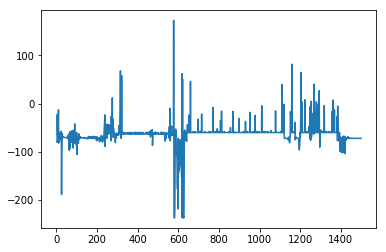

In [12]:
## TODO: Plot the rewards.
plt.plot(counter, totalRewards)

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**: I specified the task of trying to get the drone to hover at x: 0, y: 0, z: 30 with the default original starting position. 

As my aim was to be as close to the hover point as possible, I penalized the distance away from the x, y coordinates by **100*(abs(self.sim.pose[:2] - self.target_pos[:2])).sum()**. This was also backed up by **- 50 * (abs(self.sim.v[:2].sum()))** which penalizes the drove for having velocity in the x and y axis.

Initially, the z axis was included in the measure above but moved out as I noticed the drone was just crashing to the ground and not flying enough. Therefore, I added extra weighting to the z axis. After doing this, I noticed the drone just kept climbing up and up and not actually hovering. As a result, I provided great rewards for the drone's z axis veloticty to be going upwards. However, penalized it very heavily if it's velocity was still going up once it had crossed the hovering point on the z axis.

I did not want the drone to be spinning. Just want it to climb up in a stable fashion. As a result, I added a penality for it having any angular velocity by **- 5*(abs(self.sim.angular_v.sum()))**. Additionally, I didn't want the drone to tilt or spin. This would happen if any of the rotors were going faster or slower than the others. Therefore, penalized the angular acceleration as well by **- 3 *(abs(self.sim.angular_accels.sum()))**.

The sole aim of the reward function was to increase the altitude of the drone whilst stablely hovering over the origin.


**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**: I used the example classes to create a DDPG agent. In the Actor and Critic classes, I modified the neural network layers to add **batch_normalization** and **dropout** with probability of **0.2** for both the Actor and Critic classes. Additionally, used **relu** as the activation function in both classes for the intermediatiary layers in both classes. For the actor class, I used Sigmoid as the activation function in the final layer. 

The default values were used for alpha, gamma and epsilon. For **gamma**, the default value of **0.99** is a good value as it gives positive current reinforcement for good actions. However, it's also able to penalize any present action which might be good in the short term but severely, negatively affect the future.

**Actor - Batch Normalization, Dropout (prob=0.2), Activation='relu'**

- Dense(state_size)
- Dense(32)
- Dense(64)
- Dense(128)
- Dense(64)
- Dense(action_size, activation='sigmoid')

** Critic (state pathway) - Batch Normalization, Dropout (prob=0.2), Activation='relu'**

- Dense(state_size)
- Dense(32)
- Dense(64)
- Dense(128)

** Critic (action pathway) - Batch Normalization, Dropout (prob=0.2), Activation='relu'**

- Dense(action_size)
- Dense(32)
- Dense(64)
- Dense(128)

The layers between the critic and actor were combined with a relu activation function.

** Critic - Activation='relu'**

- Dense(1)

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**: This was not an easy task to learn. There were four rotors that had to be controlled independently. This made the task challenging due to the high number of variables that were changing between each episode. 
Having initially started off with the default architectures of the Actor and Critic classes; for both I added more layers and applied normalization techniques such as **dropout** and **batch normalization** to help it learn.

I am not sure if the drone learnt the task correctly in this project. It seemed to occasionally do really well and go near the hover point. (I got this as I had edited the task.py's step function to print of the current position at each step. Also the high reward.) On other attempts, it would be at a completely different location and have very low reward. This is clearly shown by the reward plot and the prints of the rewards above. 

The final performance wasn't great. It seems really random by how it has performed. 

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**: The hardest part of the project definitely was getting started. The other projects had examples that we had done previously to act as a guide for the final project. This did not. Furthermore, this was just a more complex project. However, the sample classes given did a lot with getting started.     

I really enjoyed working on this project as it's about deep reinforcement learning which is so often in this news for the work done by OpenAI for the Dota 2 bots, AlphaGo and the other games. Furthermore, to work on this project, I got to learn a lot about Monte Carlo methods, MDP and Temporal Learning which are all extremely important to learn anything about agent based systems.                 

I found it really odd about how the drone suddenly performed really well by going to the hoverpoint but on subsequent episodes, it didn't perform well at all.